# Climate Change Belief Analysis
## Predict an individual’s belief in climate change based on historical tweet data - for EDSA Online

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies..

## Data used:

Data
The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were collected. Each tweet is labelled as one of the following classes:



Variable definitions
sentiment: Sentiment of tweet

message: Tweet body

tweetid: Twitter unique id

Files available for download
train.csv - You will use this data to train your model.

test.csv - You will use this data to test your model.

SampleSubmission.csv - is an example of what your submission file should look like. The order of the rows does not matter, but the names of the tweetid's must be correct.

# Import all libaries

In [5]:
import numpy as np
import pandas as pd
import re
import string

import matplotlib.pyplot as plt
%matplotlib inline

#NLP libaries used
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer

#Splitting/ generating matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#Various types of imbalance methodes used:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks

#Models for prediction and additional sources used
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV


## Importing Data from CSV

In [6]:
train_df = pd.read_csv(r'C:\Users\Magdalena\Desktop\kaggle\climate-change-edsa2020-21\train.csv')
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [7]:
test_df = pd.read_csv(r'C:\Users\Magdalena\Desktop\kaggle\climate-change-edsa2020-21\test.csv')
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


# Imbalanced Sentiments
Its important to see if your data is balance or not. This is to ensure that there is no bais when the data set will be making predictions as standard algorithms will make us of the majortity sentiment and won't take into consideration the data distribution.

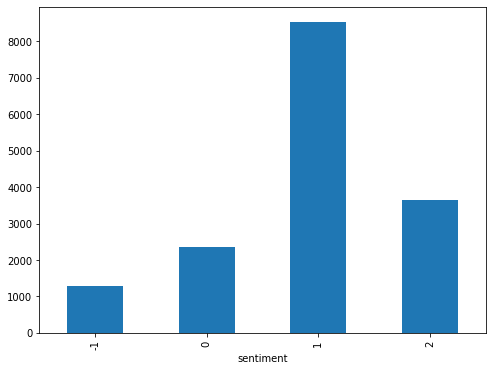

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
train_df.groupby('sentiment').message.count().plot.bar(ylim=0)
plt.show()

Sentiment are classify as the following:

- 2: News: the tweet links to factual news about climate change
- 1: Pro: the tweet supports the belief of man-made climate change
- 0: Neutral: the tweet neither supports nor refutes the belief of man-made climate changes
- -1: Anti: the tweet doesn't believe in man-made climate change

In [9]:
train_df['sentiment'].value_counts(dropna=False)

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

From the above value data we can see that the data set is *inbalance* and that we should aim to balance the data once we begin with fitting models.

# Data Preprocessing/ Cleaning

# Text Preprocessing

Removing all the noise in the tweets by replacing or removing:

- Working with ascii
- URLs
- Usernames
- Hashtags
- Punctuation
- repeating of RTs

After the noise has been remove the following should take place:
- Make all tweets lowercase
- Remove all stop words from tweet
- Stem/ or Lemmatize the words

In [10]:
#Assign dataframes to new variables (easier to replace a mistake):
train = train_df
test = test_df

In [11]:
#Funcation will pre-process/ clean the tweets accoring to each describtion below:

def data_clean(msg):
    msg = msg.encode('ascii', 'ignore').decode() #accepts custom handlers for errors in ascii
    msg = re.sub(r'http\S+', 'url', msg) #replace are urls/https with the wording url
    #msg = re.sub(r'@[A-Za-z0-9]+','',msg) # remove username
    msg = re.sub(r'RT', '', msg) # remove the word RT/ aka Retweet from the message
    msg = re.sub('[%s]' % re.escape(string.punctuation), '', msg) #remove all punctuation to see all print (sting.punctuation)
    msg = re.sub(r'[0-9]', '', msg) # remove all digits from message
    msg = msg.lower() #make whole mage into lower case 
    msg = re.sub(r'\s+',' ', msg) # remove white spave from message
       
    return msg                

In [12]:
#Apply above function on both the test and training set and asssign cleaned data to column tweet:
train['tweet'] = train['message'].apply(lambda msg:data_clean(msg))
test['tweet'] = test['message'].apply(lambda msg:data_clean(msg))

In [13]:
#Tokenise the tweet to ensure that we can peform Lemmatization and also remove stop words from each tweet

tokeniser = TreebankWordTokenizer()
train['tokens'] = train['tweet'].apply(tokeniser.tokenize)
test['tokens'] = test['tweet'].apply(tokeniser.tokenize)

In [14]:
#Functions for lemmatize of the words

def lemma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]

In [15]:
#Apply the lemmatizer function to dataframe and genrate a new column

lemmatizer = WordNetLemmatizer()
train['lemma'] = train['tokens'].apply(lemma, args=(lemmatizer, ))
test['lemma'] = test['tokens'].apply(lemma, args=(lemmatizer, ))


In [16]:
#Functions for stopwords removal
def remove_stop_words(tokens):
    return [t for t in tokens if t not in stopwords.words('english')]

In [17]:
#Apply the stop function to dataframe and genrate a new column

train['w_stp'] = train['tokens'].apply(remove_stop_words)
test['w_stp'] = test['tokens'].apply(remove_stop_words)

In [18]:
#Ensure that data is in a list format for when creating so that it can be readable for the Modeling

train['final']=[" ".join(x) for x in train['w_stp'].values]
test['final']=[" ".join(x) for x in test['w_stp'].values]

In [19]:
train.head() #Recalling up headers to ensure the correct data gets select When splitting

,sentiment,message,tweetid,tweet,tokens,lemma,w_stp,final
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...",polyscimajor epa chief doesnt think carbon dio...
1,1,It's not like we lack evidence of anthropogeni...,126103,its not like we lack evidence of anthropogenic...,"[its, not, like, we, lack, evidence, of, anthr...","[it, not, like, we, lack, evidence, of, anthro...","[like, lack, evidence, anthropogenic, global, ...",like lack evidence anthropogenic global warming
2,2,RT @RawStory: Researchers say we have three ye...,698562,rawstory researchers say we have three years ...,"[rawstory, researchers, say, we, have, three, ...","[rawstory, researcher, say, we, have, three, y...","[rawstory, researchers, say, three, years, act...",rawstory researchers say three years act clima...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired was a pivotal year in the w...,"[todayinmaker, wired, was, a, pivotal, year, i...","[todayinmaker, wired, wa, a, pivotal, year, in...","[todayinmaker, wired, pivotal, year, war, clim...",todayinmaker wired pivotal year war climate ch...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,soynoviodetodas its and a racist sexist clima...,"[soynoviodetodas, its, and, a, racist, sexist,...","[soynoviodetodas, it, and, a, racist, sexist, ...","[soynoviodetodas, racist, sexist, climate, cha...",soynoviodetodas racist sexist climate change d...


In [20]:
test.head() #Recalling up headers to ensure the correct data gets select When splitting

,message,tweetid,tweet,tokens,lemma,w_stp,final
0,Europe will now be looking to China to make su...,169760,europe will now be looking to china to make su...,"[europe, will, now, be, looking, to, china, to...","[europe, will, now, be, looking, to, china, to...","[europe, looking, china, make, sure, alone, fi...",europe looking china make sure alone fighting ...
1,Combine this with the polling of staffers re c...,35326,combine this with the polling of staffers re c...,"[combine, this, with, the, polling, of, staffe...","[combine, this, with, the, polling, of, staffe...","[combine, polling, staffers, climate, change, ...",combine polling staffers climate change womens...
2,"The scary, unimpeachable evidence that climate...",224985,the scary unimpeachable evidence that climate ...,"[the, scary, unimpeachable, evidence, that, cl...","[the, scary, unimpeachable, evidence, that, cl...","[scary, unimpeachable, evidence, climate, chan...",scary unimpeachable evidence climate change al...
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,karoli morgfair osborneink dailykos putin got ...,"[karoli, morgfair, osborneink, dailykos, putin...","[karoli, morgfair, osborneink, dailykos, putin...","[karoli, morgfair, osborneink, dailykos, putin...",karoli morgfair osborneink dailykos putin got ...
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,fakewillmoore female orgasms cause global war...,"[fakewillmoore, female, orgasms, cause, global...","[fakewillmoore, female, orgasm, cause, global,...","[fakewillmoore, female, orgasms, cause, global...",fakewillmoore female orgasms cause global warm...


# Split data into Train X and Y and Test X

In [14]:
#Split data according to what is needed:
# y values will be the sentiment that we are using to predict outcome
# X values are the actual tweet that's been cleaned up

y = train['sentiment']
X = train['final']

In [15]:
#The Test set also went through the cleaning process and there fore will assign only the final tweet to new variable
testx = test['final']

In [50]:
#TfidfVectirorizer with a limitation on min_df for only 4 values
tfidf = TfidfVectorizer(min_df=4)

In [51]:
#Apply the tfidf on the Train and Test set to convert all data into matrix
X_vec = tfidf.fit_transform(X)
test_ve = tfidf.transform(testx)

In [52]:
#Split the dataset into train and test sets on the data that's been converted into a matrix:

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.25, random_state=27)

In [20]:
#Print the shape of the sets where (rows, columns) of each one after splitting

print(X_train.shape)
print(y_train.shape)

(11864, 13248)
(11864,)


# Imblance dataset

I will make use of 4 different types to work with imblance data sets: 
- SMOTE
- ADASYN
- RandomUnderSampler
- Tomek Links


# SMOTE

In [24]:
# create the  object with the desired sampling strategy.
smote = SMOTE(sampling_strategy='minority')

#fit model on train set
x_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

In [25]:
print(x_train_smote.shape)
print(y_train_smote.shape)

(17248, 4782)
(17248,)


# ADASYN

In [26]:
# create the object to resample the majority class.
adasyn = ADASYN(sampling_strategy="minority")

# fit the object to the training data.
x_train_adasyn, y_train_adasyn = adasyn.fit_sample(X_train, y_train)

In [27]:
print(x_train_adasyn.shape)
print(y_train_adasyn.shape)

(17267, 4782)
(17267,)


# Undersampler

In [28]:
# create the object.
under_sampler = RandomUnderSampler()

# fit the object to the training data.
x_train_under, y_train_under = under_sampler.fit_sample(X_train, y_train)

In [29]:
print(x_train_under.shape)
print(y_train_under.shape)

(3952, 4782)
(3952,)


# TomekLinks

In [53]:
tomek_links = TomekLinks()

# fit the object to the training data.
x_train_tl, y_train_tl = tomek_links.fit_sample(X_train, y_train)

In [22]:
print(x_train_tl.shape)
print(y_train_tl.shape)

(10625, 13248)
(10625,)


# 1. SGD Classifier Model

In [32]:
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, y_train)
pred_sgd = sgd.predict(X_test)

In [38]:
f1_score(y_test, pred_sgd, average="macro")

0.6343619963322383

In [33]:
sgd_smote = SGDClassifier(max_iter=1000, tol=1e-3)
sgd_smote.fit(x_train_smote, y_train_smote)
pred_sgd_smote = sgd_smote.predict(X_test)

In [39]:
f1_score(y_test, pred_sgd_smote, average="macro")

0.5947483090822916

In [34]:
sgd_adsyn = SGDClassifier(max_iter=1000, tol=1e-3)
sgd_adsyn.fit(x_train_adasyn, y_train_adasyn)
pred_sgd_adsyn = sgd_adsyn.predict(X_test)

In [38]:
f1_score(y_test, pred_sgd_adsyn, average="macro")

0.575020769688493

# Outcome on the SGD Classifier:
Submission score of: 0.72498


In [54]:
sgd_tk = SGDClassifier(max_iter=1000, tol=1e-3)
sgd_tk.fit(x_train_tl, y_train_tl)
pred_sgd_tk = sgd_tk.predict(X_test)

In [39]:
f1_score(y_test, pred_sgd_tk, average="macro")

0.6322979935198003

Generate submission:
1. Apply model on the Test.csv which is now know as test_vec (the data set that's been vectorized)
2. "Concat" the Tweetid with the sentiment and export to csv

In [45]:
y_preds = sgd_tk.predict(test_ve)
test['sentiment'] = y_preds
test[['tweetid', 'sentiment']].to_csv('SGDClassifier_TL.csv', index = False)

# 2. RandomForestClassifier

All 4 dataset were use on the model and the 

In [45]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
f1_score(y_test, rfc_pred, average="macro")

0.553892535018651

In [41]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
f1_score(y_test, rfc_pred, average="macro")

0.5528241774044149

In [46]:
rfc_s = RandomForestClassifier()
rfc_s.fit(x_train_smote, y_train_smote)
rfc_pred_s = rfc.predict(X_test)
f1_score(y_test, rfc_pred_s, average="macro")

0.553892535018651

In [47]:
rfc_a = RandomForestClassifier()
rfc_a.fit(x_train_adasyn, y_train_adasyn)
rfc_pred_a = rfc_a.predict(X_test)
f1_score(y_test, rfc_pred_a, average="macro")

0.5908387645405553

# Outcome of the RandomForestClassifier ADASYN sample:
Submission Score on kaggle: 0.70021

In [43]:
rfc_a = RandomForestClassifier()
rfc_a.fit(x_train_adasyn, y_train_adasyn)
rfc_pred_a = rfc_a.predict(X_test)
f1_score(y_test, rfc_pred_a, average="macro")

0.5922242848150339

In [47]:
y_preds = rfc_a.predict(test_ve)
test['sentiment'] = y_preds
test[['tweetid', 'sentiment']].to_csv('RFC_ADASYN.csv', index = False)

# 3. SVM Classifier Kernel: Linear and rbf

In [51]:
svml = SVC(C=20000, gamma= 'auto', kernel='linear')
svml.fit(X_train, y_train)
predl = svml.predict(X_test)
f1_score(y_test, predl, average="macro")

0.552650261028376

In [52]:
svm = SVC(C=20000, gamma= 'auto', kernel='rbf')
svm.fit(X_train, y_train)
predl = svm.predict(X_test)
f1_score(y_test, predl, average="macro")

0.6176320400179927

In [53]:
svm_tll = SVC(C=20000, gamma= 'auto', kernel='linear')
svm_tll.fit(x_train_tl, y_train_tl)
predtl = svm_tll.predict(X_test)
f1_score(y_test, predtl, average="macro")

0.5540851863654243

In [65]:
y_preds = svm_tl.predict(test_ve)
test['sentiment'] = y_preds
test[['tweetid', 'sentiment']].to_csv('SVM_yl_rbf_normal.csv', index = False)

Submission score: 0.68551

In [57]:
asvm_l = SVC(C=20000, gamma= 'auto', kernel='linear')
asvm_l.fit(x_train_adasyn, y_train_adasyn)
apredl = asvm_l.predict(X_test)
f1_score(y_test, apredl, average="macro")

0.5459412669853071

In [58]:
asvm = SVC(C=20000, gamma= 'auto', kernel='rbf')
asvm.fit(x_train_adasyn, y_train_adasyn)
apred = asvm.predict(X_test)
f1_score(y_test, apred, average="macro")

0.6053126594427288

In [59]:
ssvm_l = SVC(C=20000, gamma= 'auto', kernel='rbf')
ssvm_l.fit(x_train_smote, y_train_smote)
spred_l = ssvm_l.predict(X_test)
f1_score(y_test, spred_l, average="macro")

0.6056766645904647

In [60]:
ssvm = SVC(C=20000, gamma= 'auto', kernel='linear')
ssvm.fit(x_train_smote, y_train_smote)
spred = ssvm.predict(X_test)
f1_score(y_test, spred, average="macro")

0.54477014829483

In [27]:
svm_tl = SVC(kernel='rbf')
svm_tl.fit(x_train_tl, y_train_tl)
pred_tl = svm_tl.predict(X_test)
f1_score(y_test, pred_tl, average="macro")

0.5840451306187933

Hyperparameter tuning:
- First started with Cs = [0.001, 0.01, 0.1, 1, 10] and gammas = [0.001, 0.01, 0.1, 1]
- Played around with the Cs and gammas ended with prefered C: 10 and gamma = 1
- Kernel prevernce rbf

In [31]:
#parameter tuning 
def param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds, n_jobs=-1)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [32]:
params = param_selection(X_train, y_train,5)
print (params)

{'C': 10, 'gamma': 0.1}


In [56]:
final_svm_tl = SVC(kernel='rbf', C=10, gamma = 1)
final_svm_tl.fit(x_train_tl, y_train_tl)
svc_pred = final_svm_tl.predict(X_test)

In [57]:
f1_score(y_test, svc_pred, average="macro")

0.6388085111633679

# Final Submission:

#Outcome of the SVM Classifier, with C=10 and gamma = 1 on Tomek links dataset
Submission Score on kaggle: 0.73103

In [58]:
y_preds = final_svm_tl.predict(test_ve)
test['sentiment'] = y_preds
test[['tweetid', 'sentiment']].to_csv('SVM__grid_tl_rbf_normal.csv', index = False)

In [64]:
#Tried to make another prediction with gridsearch although the F1- Score is much beter with C as 100
#the final score on kaggle only got to 0.7307
#parameter tuning 
#def param_selection(X, y, nfolds):
#Cs = [0.1, 1, 10, 100]
#gammas = [0.1, 1, 10, 100]
#param_grid = {'C': Cs, 'gamma' : gammas}
#grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds, n_jobs=-1)
#grid_search.fit(X, y)
#grid_search.best_params_
#return grid_search.best_params_

In [65]:
#params = sparam_selection(x_train_tl, y_train_tl,5)
#print (params)

{'C': 100, 'gamma': 1}


In [61]:
#final_svm2_tl = SVC(kernel='rbf', C=100, gamma = 1)
#final_svm2_tl.fit(x_train_tl, y_train_tl)
#svc_pred = final_svm2_tl.predict(X_test)

In [62]:
#f1_score(y_test, svc_pred, average="macro")

0.6391008116228727

In [63]:
y_preds = final_svm2_tl.predict(test_ve)
test['sentiment'] = y_preds
test[['tweetid', 'sentiment']].to_csv('SVM__grid_100_tl_rbf_normal.csv', index = False)